Author: John Maidens (johnmaidens@gmail.com)

## Table of Contents <a name="toc"></a>
1. [Introduction](#introduction)
2. [Simulation](#simulation)
    1. Simulated dataset generation
    2. Independent Component Analysis
    3. MUSIC
3. [Hardware](#hardware)
    1. Experimental setup
    2. Independent Component Analysis
    3. MUSIC
4. [Discussion](#discussion)

# Introduction <a name="introduction"></a>

This is an implemention of the MUltiple SIgnal Classification (MUSIC) algorithm as introduced in [1]. It is implemented for the purpose of audio source localization using a simple audio propagation model that only accounts for signal attenuation. We compare MUSIC against a simple baseline of Independent Component Analysis (ICA), which attempts to separate the audio sources blindly, without knowledge of the array geometry. 

This notebook is the result of a weekend project I did in October 2021 with the goal of learning more about audio source separation algorithms. To date, I have found that the algorithms work amazingly well on simulated data, but there is still room for improvement on actual experimental data. As next steps I would like to perform some experiments to better characterize the hardware microphone array and explore more complex models of sound wave propagation that account for time of arrival as well as phase differences. 

At a high level, the MUSIC algorithm works by computing "signal" and "noise" subspaces using the covariance matrix of the measured data, then identifying the sources as the locations farthest from the noise subspace. The steps of the MUSIC algorithm, as written in the original paper [1], are outlined below. In my implementation I have attempted to assign variable names to match the nomenclature used in the original paper as much as possible. 

![music.png](music.png)

[1] Schmidt, R. (1986). Multiple emitter location and signal parameter estimation. IEEE transactions on antennas and propagation, 34(3), 276-280. Available: [here](https://msol.people.uic.edu/ECE531/papers/Multiple%20Emitter%20Location%20and%20Signal%20Parameter%20Estimation.pdf)

In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from sklearn.decomposition import FastICA

#  Simulation  <a name="simulation"></a>

## Simulated dataset generation <a name="21"></a>

This simulated dataset allows us to demonstrate that it is possible to separate the sources, at least in the case that our model matches the true data generation process. We implement a rectangular 3-by-3 array of microphone sensors along with four simulated audio sources each playing one of four Beatles songs. Sources are mixed using a simple attenuation model. 

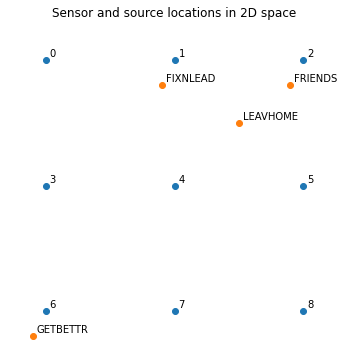

In [2]:
# Generate simulated locations of microphone array and audio sources in 2D space


def generate_sensor_locations():
    sensor_locations = []
    for y in [1, 0, -1]:
        for x in [-1, 0, 1]:
            sensor_locations.append([x, y])
    sensor_locations = np.array(sensor_locations).T
    sensor_labels = [str(i) for i in range(9)]
    return sensor_locations, sensor_labels


def generate_source_locations():
    source_locations = [
        [0.9, 0.8],
        [-0.1, 0.8],
        [-1.1, -1.2],
        [0.5, 0.5],
    ]
    source_locations = np.array(source_locations).T
    source_labels = [
        "FRIENDS",
        "FIXNLEAD",
        "GETBETTR",
        "LEAVHOME",
    ]
    return source_locations, source_labels


def plot_sensor_and_source_locations(
    sensor_locations,
    sensor_labels,
    source_locations,
    source_labels,
    plot_range=1.3,
):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    label_offset_distance = 0.03

    # Sensors
    if sensor_locations is not None:
        plt.plot(
            sensor_locations[0, :],
            sensor_locations[1, :],
            "o",
        )
        for k in range(len(sensor_labels)):
            ax.annotate(
                sensor_labels[k],
                xy=sensor_locations[:, k] + label_offset_distance,
                textcoords="data",
            )

    # Sources
    if source_locations is not None:
        plt.plot(
            source_locations[0, :],
            source_locations[1, :],
            "o",
        )
        for k in range(len(source_labels)):
            ax.annotate(
                source_labels[k],
                xy=source_locations[:, k] + label_offset_distance,
                textcoords="data",
            )

    plt.title("Sensor and source locations in 2D space")
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.axis([-plot_range, plot_range, -plot_range, plot_range])
    plt.axis("off")
    plt.show()


(
    sensor_locations,
    sensor_labels,
) = generate_sensor_locations()
(
    source_locations,
    source_labels,
) = generate_source_locations()
plot_sensor_and_source_locations(
    sensor_locations,
    sensor_labels,
    source_locations,
    source_labels,
)

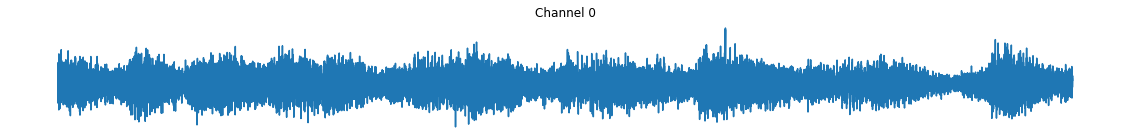

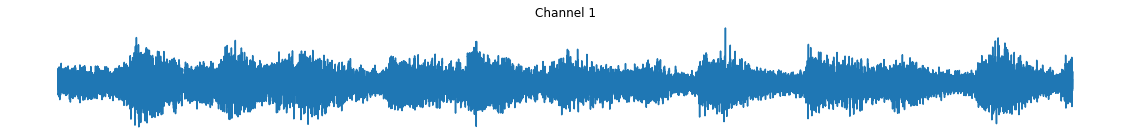

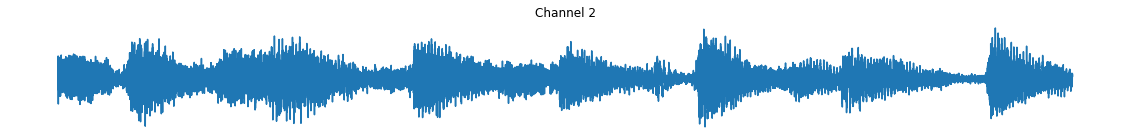

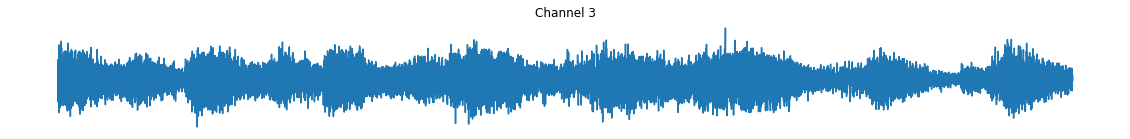

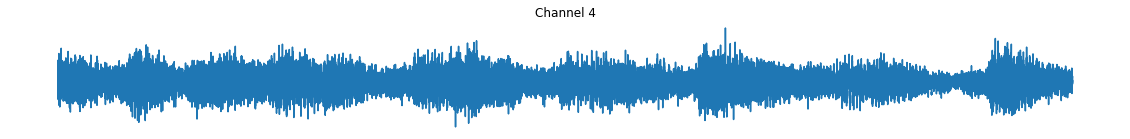

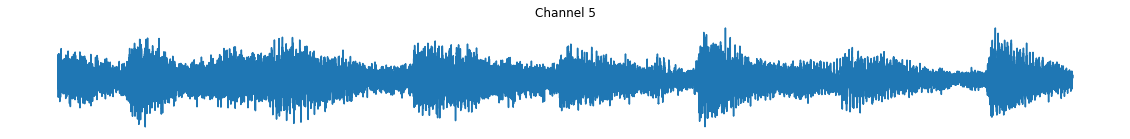

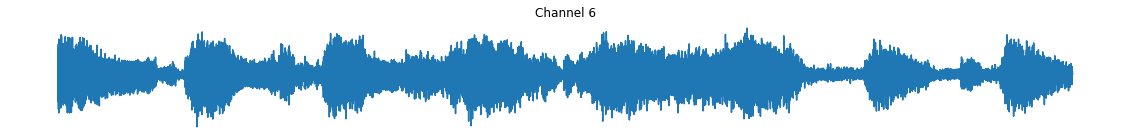

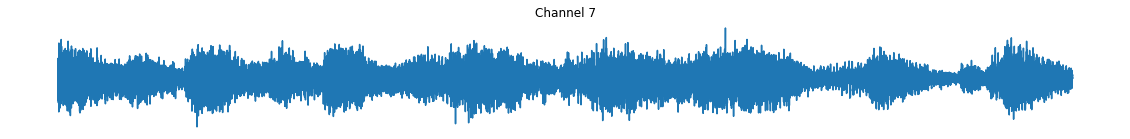

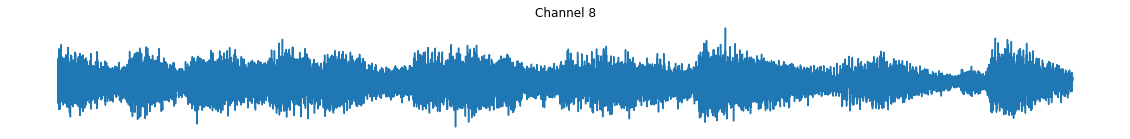

In [3]:
# Step 0: Generate simulated sensor data


def load_audio_clip_mono(filename, MAX_AUDIO_DURATION=84659):
    fs, stereo_audio = wavfile.read(filename + ".WAV")
    mono_audio = np.mean(stereo_audio, 1)
    return fs, mono_audio[:MAX_AUDIO_DURATION]


def directional_mode_vector(sensor_locations, theta):
    """Directional mode vector corresponding to source j with location theta_j"""
    # Assumption: sound amplitude decreases with distance r from source as 1/r
    return 0.2 / (np.linalg.norm(sensor_locations.T - theta, axis=1))


def add_iid_white_noise(AF, sigma=0.1):
    W = sigma * np.random.randn(*AF.shape)
    X = AF + W
    return X


def simulate_sensor_data(sensor_locations, source_locations, source_labels):
    A = np.zeros(
        (
            sensor_locations.shape[1],
            source_locations.shape[1],
        )
    )
    for j in range(source_locations.shape[1]):
        A[:, j] = directional_mode_vector(
            sensor_locations, source_locations[:, j]
        )

    F = []
    for filename in source_labels:
        fs, x = load_audio_clip_mono(filename)
        F.append(x)
    F = np.array(F)

    AF = np.dot(A, F)
    X = add_iid_white_noise(AF, sigma=0.1)
    return X, AF, fs


def visualize_multichannel_audio_array(fs, x, num_channels=1):
    for channel_index in range(num_channels):
        plt.figure(figsize=(20, 2))
        plt.plot(x[:, channel_index])
        plt.axis("off")
        plt.title(f"Channel {channel_index}")
        plt.show()

        IPython.display.display(
            IPython.display.Audio(data=x[:, channel_index], rate=fs)
        )


X, AF, fs = simulate_sensor_data(
    sensor_locations, source_locations, source_labels
)
visualize_multichannel_audio_array(fs, X.T, num_channels=9)

In [4]:
# Notice that rank of (AF)(AF)* is the number of sources

np.linalg.matrix_rank(AF.dot(AF.T))

4

In [5]:
# The covariance matrix S = E[XX*] is full rank due to noise

S = 1.0 / X.shape[1] * X.dot(X.T)
np.linalg.matrix_rank(S)

9

## Baseline algorithm: Fast Independent Component Analysis (ICA)

As a simple baseline, we implement Independent Component Analysis (ICA) to separate the sources. At a high level, ICA attempts to find a decomposition of the measured data such that each component is minimally "Gaussian". More details about the FastICA algorithm used can be found on Wikipedia https://en.wikipedia.org/wiki/FastICA and the scikit-learn documentation https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html. 

Below we estimate the independent components of the signal given only the data matrix X. The scikit-learn implementation works quite well out of the box, and is simple to use because it is "blind" (requires no information about the array geometry). But it does not remove noise as well as the MUSIC algorithm below which incorporates information about the array geometry. 

In [6]:
ica = FastICA(n_components=5)
ica_result = ica.fit_transform(X.T)

In [7]:
estimated_source_id = 3
IPython.display.Audio(data=ica_result[:, estimated_source_id], rate=fs)

## Implementation of the MUSIC algorithm

In contrast with the blind source separation above, the MUltiple SIgnal Classification (MUSIC) algorithm incorporates knowledge of the sensor locations and a sound propagation model to improve performance. 

Below we estimate the source locations given the data matrix X using MUSIC. 

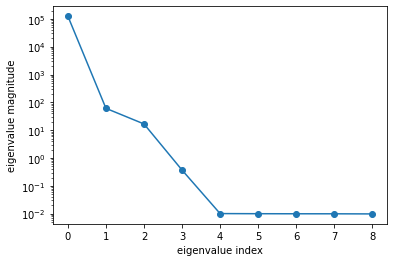

In [8]:
# MUSIC algorithm step 1: Calculate eigenstructure of S in the metric
# of noise covariance matrix S0


def eigen_decomposition(X, num_sources=len(source_labels)):
    """Computes eigenvalues, signal modes E and noise modes En for data X"""
    X = X.astype("float64")
    S = 1.0 / X.shape[1] * X.dot(X.T)
    # This just computes the eigenvalues in euclidean metric,
    # which is fine for iid noise
    D, E = np.linalg.eig(S)
    # Assumption: number of sources is known. This could also be
    # estimated from computed eigenvalues
    M = len(source_labels)
    idx = D.argsort()[::-1]
    eigenvalues = D[idx]
    E = E[:, idx]
    E_noise_subspace = E[:, num_sources : len(E)]  # Noise eigenvectors

    return eigenvalues, E, E_noise_subspace


# Eigenvalues corresponding to sources are larger than eigenvalues corresponding to noise
eigenvalues, E, E_noise_subspace = eigen_decomposition(X)

plt.semilogy(eigenvalues, "o-")
plt.ylabel("eigenvalue magnitude")
plt.xlabel("eigenvalue index")
plt.show()

In [9]:
# MUSIC step 3: Evaluate P_MU(theta) versus theta


def P_MU(theta, sensor_locations, E_noise_subspace):
    a_theta = directional_mode_vector(sensor_locations, theta)
    return 1.0 / a_theta.T.dot(E_noise_subspace).dot(E_noise_subspace.T).dot(
        a_theta
    )


def define_mesh_grid(
    grid_extent,
    num_grid_points,
    sensor_locations,
    E_noise_subspace,
):
    x_all = np.linspace(-grid_extent, grid_extent, num_grid_points)
    y_all = np.linspace(-grid_extent, grid_extent, num_grid_points)
    P_grid = np.array(
        [
            [
                P_MU(
                    [x, y],
                    sensor_locations,
                    E_noise_subspace,
                )
                for x in x_all
            ]
            for y in y_all
        ]
    )
    return x_all, y_all, P_grid


x_all, y_all, P_grid = define_mesh_grid(
    1.5, 500, sensor_locations, E_noise_subspace
)

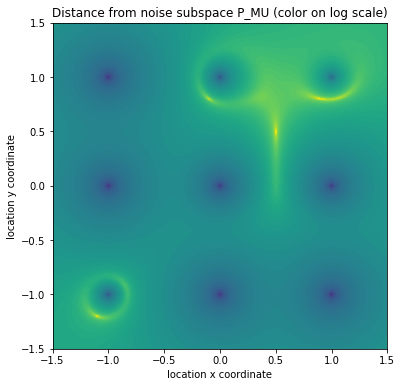

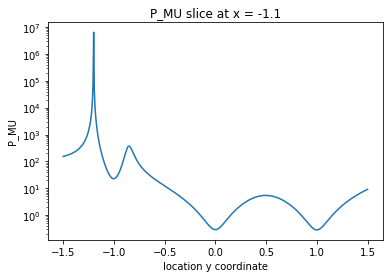

In [10]:
# Visualize the map of P_MU values


def contour_plot(x_all, y_all, P_grid, color_scale="log"):
    xx, yy = np.meshgrid(x_all, y_all)

    plt.figure(figsize=(6, 6))
    if color_scale == "log":
        plt.contourf(xx, yy, np.log(P_grid), 100)
    elif color_scale == "linear":
        plt.contourf(xx, yy, P_grid, 100)
    else:
        raise ValueError(f"Invalid color_scale {color_scale}")
    plt.xlabel("location x coordinate")
    plt.ylabel("location y coordinate")
    plt.title(
        f"Distance from noise subspace P_MU (color on {color_scale} scale)"
    )
    plt.show()


def graph_through_slice(x_slice):
    plt.semilogy(
        y_all,
        [
            P_MU(
                [x_slice, y],
                sensor_locations,
                E_noise_subspace,
            )
            for y in y_all
        ],
    )
    plt.xlabel("location y coordinate")
    plt.ylabel("P_MU")
    plt.title("P_MU slice at x = %.1f" % x_slice)
    plt.show()


contour_plot(x_all, y_all, P_grid, color_scale="log")
graph_through_slice(x_slice=-1.1)

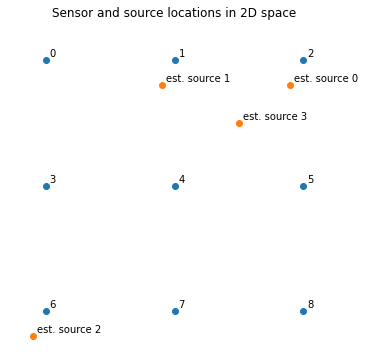

In [11]:
# Step 4: Pick peaks of P_MU(theta)

# I'm just going to cheat and use the true locations, but we could in practice
# pull the four peaks out automatically from the P_UM map
source_locations_est = source_locations
source_locations_est_labels = [
    f"est. source {i}" for i in range(source_locations_est.shape[1])
]

# Estimated source locations
plot_sensor_and_source_locations(
    sensor_locations,
    sensor_labels,
    source_locations_est,
    source_locations_est_labels,
)

In [12]:
# Step 5: Calculate the directional modes based on source location estimates


def directional_mode_matrix(sensor_locations, source_locations_est):
    A_est = np.zeros(
        (
            sensor_locations.shape[1],
            source_locations_est.shape[1],
        )
    )
    for j in range(source_locations_est.shape[1]):
        A_est[:, j] = directional_mode_vector(
            sensor_locations, source_locations_est[:, j]
        )
    return A_est


A_est = directional_mode_matrix(sensor_locations, source_locations_est)

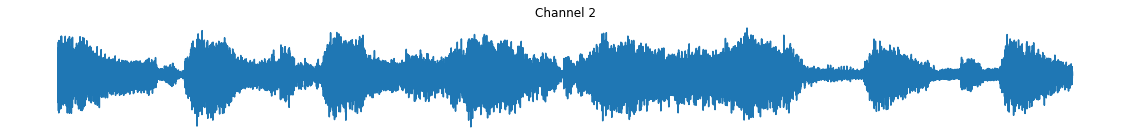

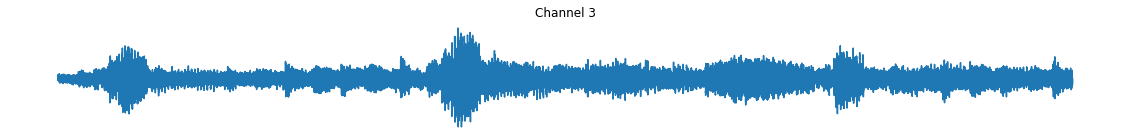

In [13]:
# Step 6 (not in paper): Solve the linear system of equations for
# audio generated by each source
#
# We see that the MUSIC algorithm is able to separate the data perfectly
# and also removes the independent white noise better than ICA

F_est = np.linalg.solve(
    A_est.T.dot(A_est),
    A_est.T.dot(X),
)

visualize_multichannel_audio_array(fs, F_est.T, num_channels=4)

# Hardware <a name="hardware"></a>

## Experimental setup 

Experimental data were generated using the Seeed Studio Respeaker Core v2 six-microphone array. This device's microphones are arranged in an evenly-spaced hexagonal geometry. A diagram showing the microphone array geometry is provided below. Additional details about the hardware can be found at the Seeed Studio wiki: https://wiki.seeedstudio.com/ReSpeaker_Core_v2.0/

![respeaker.png](respeaker.png)

A short audio recording of approximately four seconds duration was recorded by playing music through Mid-2012 MacBook Retina speakers and simultaneously speaking with the speakers and speech located at opposite ends of the microphone array, each approximately 0.3 meters from the array. The recording was captured using the default sample rate of 16 kHz. 

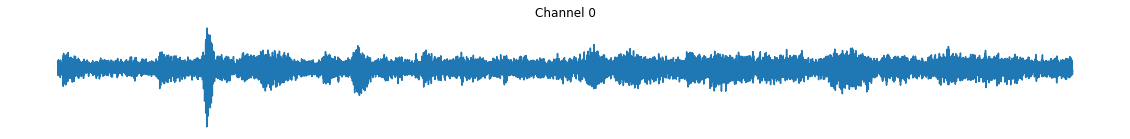

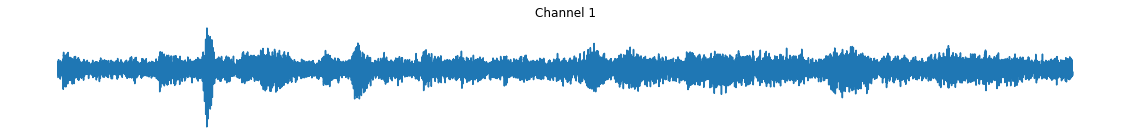

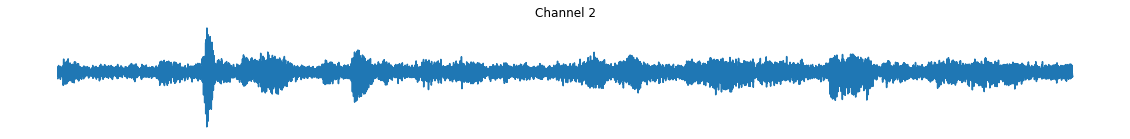

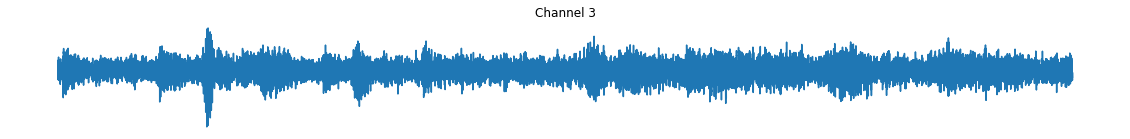

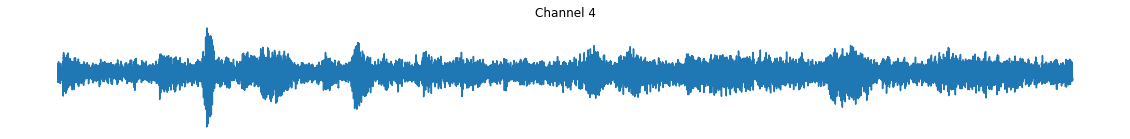

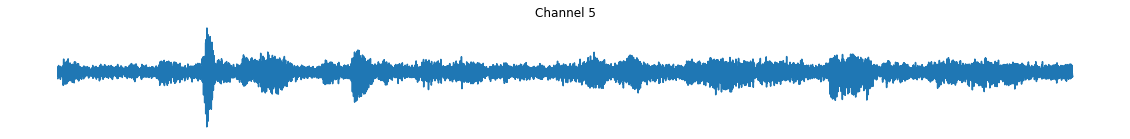

In [14]:
# Load in experimental data from the six-microphone array

num_channels = 6


def load_multichannel_audio_recording(filename, num_channels=num_channels):
    fs, x = wavfile.read(filename)
    return fs, x[:, :num_channels]


fs, x = load_multichannel_audio_recording("beamtest.wav")
visualize_multichannel_audio_array(fs, x, num_channels=6)

## Fast Independent Component Analysis (ICA)

We again use Fast ICA as a baseline source separation method

In [15]:
n_components = 3
ica = FastICA(n_components=n_components, max_iter=20000, tol=1e-13)
ica_result = ica.fit_transform(x)
ica_result.shape

(99482, 3)

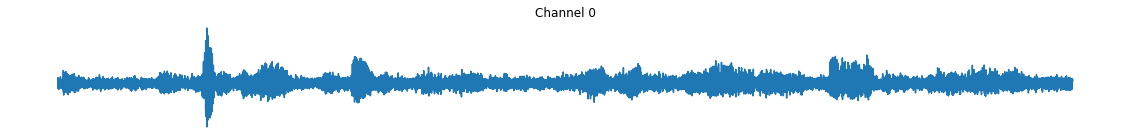

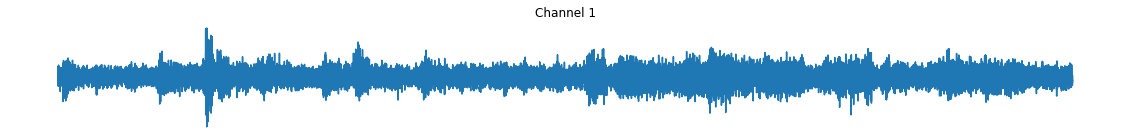

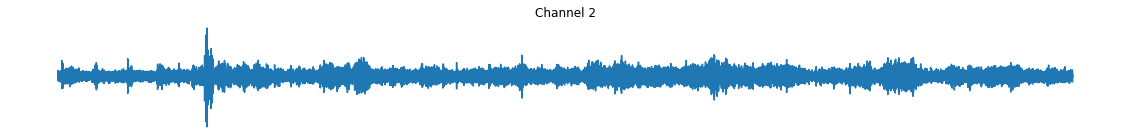

In [16]:
# Works okay but not great
# In hindsight I probably should not have used stereo speakers
# to play the music component

visualize_multichannel_audio_array(fs, ica_result, num_channels=n_components)

## MUSIC

We now apply the Multiple Signal Classification algorithm to separate sources in the real data

In [17]:
X = x.T  # Reshape data to match simulated data matrix

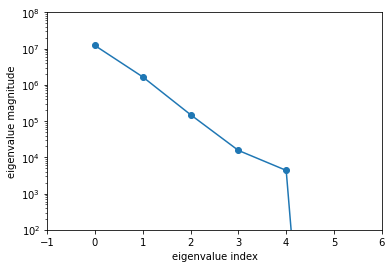

In [18]:
# MUSIC algorithm step 1: Calculate eigenstructure of the data covariance matrix

eigenvalues, E, E_noise_subspace = eigen_decomposition(X, num_sources=4)

plt.semilogy(eigenvalues, "o-")
plt.ylabel("eigenvalue magnitude")
plt.xlabel("eigenvalue index")
plt.axis(
    [
        -1,
        6,
        1e02,
        1e08,
    ]
)
plt.show()

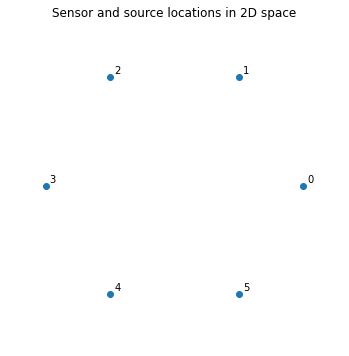

In [19]:
# Define sensor array geometry


def sensor_array_ring_geometry(n_sensors=6):
    xy = np.exp(2j * np.pi / n_sensors * np.arange(n_sensors))
    sensor_locations = np.array([xy.real, xy.imag])
    sensor_labels = [str(i) for i in range(n_sensors)]
    return sensor_locations, sensor_labels


(
    sensor_locations,
    sensor_labels,
) = sensor_array_ring_geometry(n_sensors=6)
plot_sensor_and_source_locations(sensor_locations, sensor_labels, None, None)

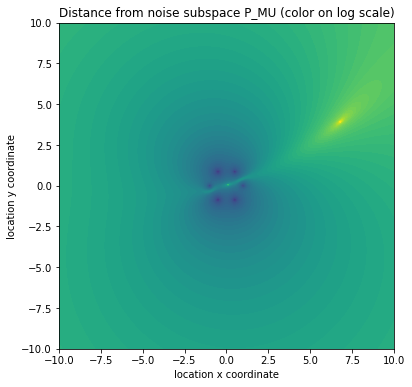

In [20]:
# MUSIC step 3: Evaluate P_MU(x, y) for each grid point (x, y)


def P_MU(theta, sensor_locations, E_noise_subspace):
    a_theta = directional_mode_vector(sensor_locations, theta)
    return 1.0 / a_theta.T.dot(E_noise_subspace).dot(E_noise_subspace.T).dot(
        a_theta
    )


def define_mesh_grid(
    grid_extent,
    num_grid_points,
    sensor_locations,
    E_noise_subspace,
):
    x_all = np.linspace(-grid_extent, grid_extent, num_grid_points)
    y_all = np.linspace(-grid_extent, grid_extent, num_grid_points)
    P_grid = np.array(
        [
            [
                P_MU(
                    [x, y],
                    sensor_locations,
                    E_noise_subspace,
                )
                for x in x_all
            ]
            for y in y_all
        ]
    )
    return x_all, y_all, P_grid


x_all, y_all, P_grid = define_mesh_grid(
    10.0, 500, sensor_locations, E_noise_subspace
)
contour_plot(x_all, y_all, P_grid, color_scale="log")

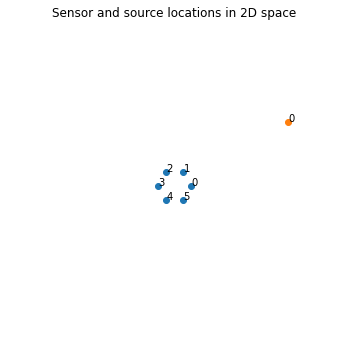

Estimated source coordinates -- x: 6.794 y: 3.908


In [21]:
# MUSIC Step 4: Estimate source location


def detect_peak(x_all, y_all, P_grid):
    amax_raveled = np.argmax(P_grid)
    amax_unraveled = np.unravel_index(amax_raveled, np.array(P_grid).shape)
    return np.array(
        [
            [
                x_all[amax_unraveled[1]],
                y_all[amax_unraveled[0]],
            ]
        ]
    ).T


source_locations_est = detect_peak(x_all, y_all, P_grid)
plot_sensor_and_source_locations(
    sensor_locations,
    sensor_labels,
    source_locations_est,
    ["0"],
    plot_range=10.0,
)
print(
    f"Estimated source coordinates -- x: {source_locations_est[0][0]:.3f} y: {source_locations_est[1][0]:.3f}"
)

In [22]:
# Step 5: Calculate the directional modes based on source location estimates

A_est = directional_mode_matrix(sensor_locations, source_locations_est)

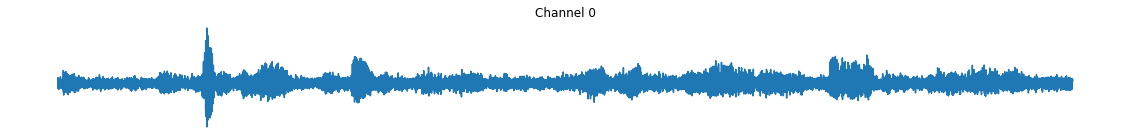

In [23]:
# Step 6 (not in paper): Solve the linear equation for audio generated by each source

F_est = np.linalg.solve(
    A_est.T.dot(A_est),
    A_est.T.dot(X),
)

# Listen to the estimated signal from the identified source
visualize_multichannel_audio_array(fs, ica_result, num_channels=1)

# Discussion <a name="discussion"></a>

The results presented suggest that MUSIC is a powerful method for identification and separation of audio sources. However, getting it to work on the real hardware as well as it works in simulation will require improved characterization and modeling of the system. 

The model used only account for attenuation of signal as a function of the distance between the source and the sensor. We have not yet validated that this attenuation model holds for the data we see in practice. And we have not explored other very important properties of sound wave propagation that we ought to be modeling including phase differences between mics and time of arrival. 
    
Another difference between the simulation and hardware setup is that the array geometry matches source geometry better in the simulation experiment than the hardware experiment. In the simulation experiment the sources are much closer to the array elements, making it much easier to estimate the distance to the source. In the hardware experiment, the sources were almost far enough from the array that a "far field" approximation to the problem would be appropriate. It is not possible to estimate distance in the far field approximation, only the direction of wavefront arrival [2]. Our experimental results agree with this principle. Based on our P_MU projection map from the hardware setup we can see that it was possible to localize one of the sources using our attenuation model but not the other(s) and that we had more sensitivity to the source's direction than to its distance. 

As next steps we would like to perform some experiments to better characterize the hardware microphone array and explore more complex models of sound wave propagation that account for time of arrival as well as phase differences. We would also like to improve the hardware experimental setup with sources that are closer to the array and that are more well-defined point sources. 
    
[2] Grondin, F. and Létourneau, D. (2018). Frequently Asked Questions, Open embeddeD Audition System (ODAS) Wiki. Available: https://github.com/introlab/odas/wiki/Frequently-Asked-Questions#estimating-the-distance-between-a-source-and-the-microphone-array 